# Step 1: Read in the data in a streaming line by line fashion #

In [1]:
import urllib2 # import urllib.request as urllib2 in Python3
import requests, io, os, StringIO
import numpy as np
import tarfile, zipfile, gzip

def unzip_from_UCI(UCI_url, dest=''):
    """
    Downloads and unpacks datasets from UCI in zip format
    """
    response = requests.get(UCI_url)
    compressed_file = io.BytesIO(response.content)
    z = zipfile.ZipFile(compressed_file)
    print ('Extracting in %s' %  os.getcwd()+'\\'+dest)
    for name in z.namelist():
        if '.csv' in name:
            print ('\tunzipping %s' %name)
            z.extract(name, path=os.getcwd()+'\\'+dest)

def gzip_from_UCI(UCI_url, dest=''):
    """
    Downloads and unpacks datasets from UCI in gzip format
    """
    response = urllib2.urlopen(UCI_url)
    compressed_file = io.BytesIO(response.read())
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    filename = UCI_url.split('/')[-1][:-3]
    with open(os.getcwd()+'\\'+filename, 'wb') as outfile:
        outfile.write(decompressed_file.read())
    print ('File %s decompressed' % filename)
            
def targzip_from_UCI(UCI_url, dest='.'):
    """
    Downloads and unpacks datasets from UCI in tar.gz format
    """
    response = urllib2.urlopen(UCI_url)
    compressed_file = StringIO.StringIO(response.read())
    tar = tarfile.open(mode="r:gz", fileobj = compressed_file)
    tar.extractall(path=dest)
    datasets = tar.getnames()
    for dataset in datasets:
        size = os.path.getsize(dest+'\\'+dataset)
        print ('File %s is %i bytes' % (dataset,size))
    tar.close()

def load_matrix(UCI_url):
    """
    Downloads datasets from UCI in matrix form
    """
    return np.loadtxt(urllib2.urlopen(UCI_url))

In [2]:
# Insert URL to download from
UCI_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
unzip_from_UCI(UCI_url, dest='bikesharing')

Extracting in /Users/adarshnair/Desktop/PyML_at_scale/Out_of_core_learning\bikesharing
	unzipping day.csv
	unzipping hour.csv


## Step 1.1: Streaming using csv.reader ##

In [6]:
# 
import os, csv
local_path = os.getcwd()
source = 'bikesharing/hour.csv'
SEP = ',' # We define this for being able to easily change it as required by the file

with open(local_path + '/' + source, 'rb') as R:
    iterator = csv.reader(R, delimiter=SEP)
    for n, row in enumerate(iterator):
        if n == 0:
            header = row
        else:
            # DATA PROCESSING placeholder
            # MACHINE LEARNING placeholder
            pass
    print ('Total rows: %i' % (n + 1))
    print ('Header: %s' % ', '.join(header))

Total rows: 17380
Header: instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt


## Step 1.2: Streaming using pandas ##

In [7]:
import pandas as pd
# Declare chunk size for each iterations fetch
CHUNK_SIZE = 1000
source = 'bikesharing/hour.csv'

with open(local_path + '/' + source, 'rb') as R:
    iterator = pd.read_csv(R, chunksize=CHUNK_SIZE) 
    for n, data_chunk in enumerate(iterator):
        print ('Size of uploaded chunk: %i instances, %i features' % (data_chunk.shape))
        # DATA PROCESSING placeholder
        # MACHINE LEARNING placeholder
        pass
    print ('Sample values: \n%s' % str(data_chunk.iloc[0]))

Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 379 instances, 17 features
Sample values: 
instant            17001
dteday        2012-12-16

## Step 1.3 Streaming using sqlite3 ##

In [8]:
import os, sys
import sqlite3, csv,glob

SEP = ','

def define_field(s):
    try:
        int(s)
        return 'integer'
    except ValueError:
        try:
            float(s)
            return 'real'
        except:
            return 'text'

def create_sqlite_db(db='database.sqlite', file_pattern=''):
    conn = sqlite3.connect(db)
    conn.text_factory = str  # allows utf-8 data to be stored

    c = conn.cursor()

    # traverse the directory and process each .csv file useful for building the db
    target_files = glob.glob(file_pattern) 

    print ('Creating %i table(s) into %s from file(s): %s' % (len(target_files), db, ', '.join(target_files)))

    for k,csvfile in enumerate(target_files):
        # remove the path and extension and use what's left as a table name
        tablename = os.path.splitext(os.path.basename(csvfile))[0]

        with open(csvfile, "rb") as f:
            reader = csv.reader(f, delimiter=SEP)

            f.seek(0)
            for n,row in enumerate(reader):
                if n==11:
                    types = map(define_field,row)
                else:
                    if n>11:
                        break      

            f.seek(0)
            for n,row in enumerate(reader):
                if n==0:

                    sql = "DROP TABLE IF EXISTS %s" % tablename
                    c.execute(sql)
                    sql = "CREATE TABLE %s (%s)" % (tablename,
                              ", ".join([ "%s %s" % (col, ct) for col, ct  in zip(row, types)]))
                    print ('%i) %s' % (k+1,sql))
                    c.execute(sql)

                    # Creating indexes for faster joins on long strings
                    for column in row:
                        if column.endswith("_ID_hash"):
                            index = "%s__%s" % ( tablename, column )
                            sql = "CREATE INDEX %s on %s (%s)" % ( index, tablename, column )
                            c.execute(sql) 

                    insertsql = "INSERT INTO %s VALUES (%s)" % (tablename,
                                ", ".join([ "?" for column in row ]))

                    rowlen = len(row)
                else:
                    # raise an error if there are rows that don't have the right number of fields
                    if len(row) == rowlen:
                        c.execute(insertsql, row)
                    else:
                        print ('Error at line %i in file %s') % (n,csvfile)
                        raise ValueError('Houston, we\'ve had a problem at row %i' % n)

            conn.commit()
            print ('* Inserted %i rows' % n)

    c.close()
    conn.close()

In [9]:
# Create the database
create_sqlite_db(db = 'bikesharing.sqlite', file_pattern='bikesharing/*.csv')

Creating 2 table(s) into bikesharing.sqlite from file(s): bikesharing/day.csv, bikesharing/hour.csv
1) CREATE TABLE day (instant integer, dteday text, season integer, yr integer, mnth integer, holiday integer, weekday integer, workingday integer, weathersit integer, temp real, atemp real, hum real, windspeed real, casual integer, registered integer, cnt integer)
* Inserted 731 rows
2) CREATE TABLE hour (instant integer, dteday text, season integer, yr integer, mnth integer, hr integer, holiday integer, weekday integer, workingday integer, weathersit integer, temp real, atemp real, hum real, windspeed real, casual integer, registered integer, cnt integer)
* Inserted 17379 rows


In [10]:
# Inner join day and hour tables ON dteday to extract data on an hourly base with information about rentals per day
import os, sqlite3
import pandas as pd

DB_NAME = 'bikesharing.sqlite'
DIR_PATH = os.getcwd()
CHUNK_SIZE = 2500

conn = sqlite3.connect(DIR_PATH + '/' + DB_NAME)
conn.text_factory = str  # allows utf-8 data to be stored  

# SQL query
sql = "SELECT H.*, D.cnt AS day_cnt FROM hour AS H INNER JOIN day as D ON (H.dteday = D.dteday)"

# Stream data using 2500 size chunks
DB_stream = pd.io.sql.read_sql(sql, 
                               conn, 
                               chunksize = CHUNK_SIZE)

for j,data_chunk in enumerate(DB_stream):
    print ('Chunk %i -' % (j+1)),
    print ('Size of uploaded chunk: %i istances, %i features' % (data_chunk.shape))
    # DATA PROCESSING placeholder
    # MACHINE LEARNING placeholder

Chunk 1 - Size of uploaded chunk: 2500 istances, 18 features
Chunk 2 - Size of uploaded chunk: 2500 istances, 18 features
Chunk 3 - Size of uploaded chunk: 2500 istances, 18 features
Chunk 4 - Size of uploaded chunk: 2500 istances, 18 features
Chunk 5 - Size of uploaded chunk: 2500 istances, 18 features
Chunk 6 - Size of uploaded chunk: 2500 istances, 18 features
Chunk 7 - Size of uploaded chunk: 2379 istances, 18 features


# Step 2: Shuffling the data to negate bias #

## Step 2.1: Shuffling in-memory ##

In [11]:
import zlib
from random import shuffle

# Will work iff RAM can hold the compressed data
def ram_shuffle(filename_in, filename_out, header=True):
    # Read the file
    with open(filename_in, 'rb') as f:
        zlines = [zlib.compress(line, 9) for line in f]
        if header:
            first_row = zlines.pop(0)
    
    shuffle(zlines)
    
    # Write the file
    with open(filename_out, 'wb') as f:
        if header:
            f.write(zlib.decompress(first_row))
        for zline in zlines:
            f.write(zlib.decompress(zline))

import os

local_path = os.getcwd()
source = 'bikesharing/hour.csv'
ram_shuffle(filename_in = local_path + '/' + source, \
                   filename_out = local_path + '/bikesharing/shuffled_hour.csv', header=True)

## Step 2.2: Shuffling in-disk ##

In [12]:
from random import shuffle
import pandas as pd
import numpy as np
import os

# If RAM cannot hold compressed data, we perform the shuffle on disk.
def disk_shuffle(filename_in, filename_out, header=True, iterations = 3, CHUNK_SIZE = 2500, SEP=','):
    for i in range(iterations):
        # Read the data
        with open(filename_in, 'rb') as R:
            iterator = pd.read_csv(R, chunksize=CHUNK_SIZE) 
            for n, df in enumerate(iterator):
                if n == 0 and header:
                    header_cols =SEP.join(df.columns)+'\n'
                df.iloc[np.random.permutation(len(df))].to_csv(str(n)+'_chunk.csv', index=False, header=False, sep=SEP)
        ordering = list(range(0,n+1))
        
        shuffle(ordering)
        
        # Write the data
        with open(filename_out, 'wb') as W:
            if header:
                W.write(header_cols)
            for f in ordering:
                with open(str(f)+'_chunk.csv', 'r') as R:
                    for line in R:
                        W.write(line)
                os.remove(str(f)+'_chunk.csv')
        filename_in = filename_out
        CHUNK_SIZE = int(CHUNK_SIZE / 2)

import os

local_path = os.getcwd()
source = 'bikesharing/hour.csv'
disk_shuffle(filename_in = local_path+'/'+source, \
                   filename_out = local_path+'/bikesharing/shuffled_hour_disk.csv', header=True)

# Step 3: Calculate feature statistics while data streaming #

## Step 3.1: Using un-shuffled data ##

In [13]:
import os, csv
local_path = os.getcwd()
source = 'bikesharing/hour.csv'
SEP=','
running_mean = list()
running_std = list()

with open(local_path + '/' + source, 'rb') as R:
    iterator = csv.DictReader(R, delimiter=SEP)
    x = 0.0
    x_squared = 0.0
    # Load data stream
    for n, row in enumerate(iterator):
        temp = float(row['temp'])
        if n == 0:
            max_x, min_x = temp, temp
        else:
            max_x, min_x = max(temp, max_x),min(temp, min_x)
        x += temp
        x_squared += temp**2
        running_mean.append(x / (n+1))
        running_std.append(((x_squared - (x**2)/(n+1))/(n+1))**0.5)
        # DATA PROCESSING placeholder
        # MACHINE LEARNING placeholder
        pass
    print ('Total rows: %i' % (n+1))
    print ('Feature \'temp\': mean=%0.3f, max=%0.3f, min=%0.3f,sd=%0.3f' \
           % (running_mean[-1], max_x, min_x, running_std[-1]))

Total rows: 17379
Feature 'temp': mean=0.497, max=1.000, min=0.020,sd=0.193


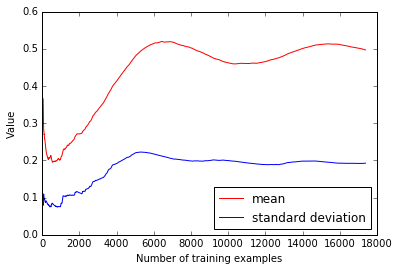

In [14]:
# Check how the mean and standard deviation vary as more data streams in.
# There is a lot of variation in the curves.
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(running_mean,'r-', label='mean')
plt.plot(running_std,'b-', label='standard deviation')

# Set y axis limits
plt.ylim(0.0,0.6)

plt.xlabel('Number of training examples')
plt.ylabel('Value') 
plt.legend(loc='lower right', numpoints= 1)
plt.show()

## Step 3.2: Using shuffled data ##

In [15]:
import os, csv
local_path = os.getcwd()
source = 'bikesharing/shuffled_hour_disk.csv'
SEP=','
running_mean = list()
running_std = list()

with open(local_path + '/' + source, 'rb') as R:
    iterator = csv.DictReader(R, delimiter=SEP)
    x = 0.0
    x_squared = 0.0
    # Load data stream
    for n, row in enumerate(iterator):
        temp = float(row['temp'])
        if n == 0:
            max_x, min_x = temp, temp
        else:
            max_x, min_x = max(temp, max_x),min(temp, min_x)
        x += temp
        x_squared += temp**2
        running_mean.append(x / (n+1))
        running_std.append(((x_squared - (x**2)/(n+1))/(n+1))**0.5)
        # DATA PROCESSING placeholder
        # MACHINE LEARNING placeholder
        pass
    print ('Total rows: %i' % (n+1))
    print ('Feature \'temp\': mean=%0.3f, max=%0.3f, min=%0.3f,sd=%0.3f' \
           % (running_mean[-1], max_x, min_x, running_std[-1]))

Total rows: 17379
Feature 'temp': mean=0.497, max=1.000, min=0.020,sd=0.193


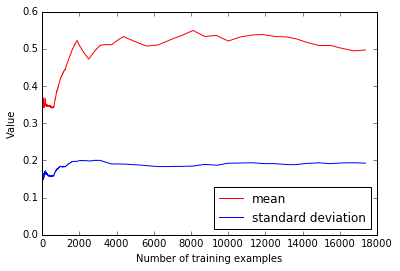

In [16]:
# Check how the mean and standard deviation vary as more data streams in.
# The curves are a lot straighter for the shuffled data.
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(running_mean,'r-', label='mean')
plt.plot(running_std,'b-', label='standard deviation')

# Set y axis limits
plt.ylim(0.0,0.6)

plt.xlabel('Number of training examples')
plt.ylabel('Value') 
plt.legend(loc='lower right', numpoints= 1)
plt.show()

# Step 4: Describing the target variable #

We will use the covtype dataset which has classification for tree types to study the target variable.

In [17]:
UCI_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
gzip_from_UCI(UCI_url)

File covtype.data decompressed


In [18]:
import os, csv
local_path = os.getcwd()
source = 'covtype.data'
SEP=','

forest_type = {1:"Spruce/Fir", 
               2:"Lodgepole Pine", 
               3:"Ponderosa Pine", 
               4:"Cottonwood/Willow", 
               5:"Aspen", 
               6:"Douglas-fir", 
               7:"Krummholz"}

forest_type_count = {value : 0 for value in forest_type.values()}
forest_type_count['Other'] = 0

lodgepole_pine = 0
spruce = 0
proportions = list()

with open(local_path+'\\'+source, 'rb') as R:
    iterator = csv.reader(R, delimiter=SEP)
    # Stream load the data
    for n, row in enumerate(iterator):
        response = int(row[-1]) # The response is the last value
        try:
            forest_type_count[forest_type[response]] +=1
            if response == 1:
                spruce += 1
            elif response == 2:
                lodgepole_pine +=1
            if n % 10000 == 0:
                proportions.append([spruce/float(n+1),\
                                    lodgepole_pine/float(n+1)])
        except:
            forest_type_count['Other'] += 1
    
    print ('Total rows: %i' % (n+1))
    print ('Frequency of classes:')
    
    for ftype, freq in sorted([(t,v) for t,v \
        in forest_type_count.iteritems()], key = \
        lambda x: x[1], reverse=True):
            print ("%-18s: %6i %04.1f%%" % \
                   (ftype, freq, freq*100/float(n+1)))

Total rows: 581012
Frequency of classes:
Lodgepole Pine    : 283301 48.8%
Spruce/Fir        : 211840 36.5%
Ponderosa Pine    :  35754 06.2%
Krummholz         :  20510 03.5%
Douglas-fir       :  17367 03.0%
Aspen             :   9493 01.6%
Cottonwood/Willow :   2747 00.5%
Other             :      0 00.0%


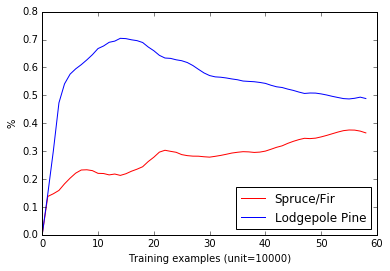

In [19]:
# Plot to show percent of training samples that are of type Lodgepole Pine and Spruce/Fir 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
proportions = np.array(proportions)
plt.plot(proportions[:,0],'r-', label='Spruce/Fir')
plt.plot(proportions[:,1],'b-', label='Lodgepole Pine')
plt.ylim(0.0,0.8)
plt.xlabel('Training examples (unit=10000)')
plt.ylabel('%') 
plt.legend(loc='lower right', numpoints= 1)
plt.show()

A shuffle is really necessary in this example if we want a stochasting online algorithm to correctly learn from the data.

# Step 5: Hashing Trick #

A work around to one-hot encoding categorical features as while the data is streaming in, we do not know how many categories we are dealing with.

In [20]:
from sklearn.feature_extraction.text import HashingVectorizer

h = HashingVectorizer(n_features = 1000, 
                      binary = True, 
                      norm = None)
sparse_vector = h.transform(['A simple toy example will make clear how it works.'])
print(sparse_vector)

  (0, 61)	1.0
  (0, 271)	1.0
  (0, 287)	1.0
  (0, 452)	1.0
  (0, 462)	1.0
  (0, 539)	1.0
  (0, 605)	1.0
  (0, 726)	1.0
  (0, 918)	1.0


In [21]:
from sklearn.feature_extraction import FeatureHasher

h = FeatureHasher(n_features=1000, 
                  non_negative=True)

example_row = {'numeric feature':3, 'another numeric feature':2, 'Categorical feature = 3':1, 'f1*f2*f3':1*2*3}
print (example_row)

{'another numeric feature': 2, 'f1*f2*f3': 6, 'numeric feature': 3, 'Categorical feature = 3': 1}


# Step 6: Implementing Stochastic Gradient Descent #

## Step 6.1: SGD for a classification problem - Forest Covertype dataset ##

In [25]:
# Step 1: RAM shuffle the data
import os
local_path = os.getcwd()
source = 'covtype.data'
ram_shuffle(filename_in= local_path + '/' + source, \
            filename_out=local_path + '/shuffled_covtype.data', \
            header=False)

In [26]:
import csv, time
import numpy as np
from sklearn.linear_model import SGDClassifier

source = 'shuffled_covtype.data'
SEP=','
forest_type = [t+1 for t in range(7)]

# Define the classifier
SGD = SGDClassifier(loss='log', 
                    penalty=None, 
                    random_state = 1, 
                    average=True)
accuracy = 0
holdout_count = 0
prog_accuracy = 0
prog_count = 0
cold_start = 200000
k_holdout = 10

with open(local_path + '/' + source, 'rb') as R:
    iterator = csv.reader(R, delimiter=SEP)
    
    # Iterate through the streaming data
    for n, row in enumerate(iterator):
        if n > 250000: # Reducing the running time of the experiment
            break 
        
        # Data processing
        # Target variable is covertype, the last column value
        response = np.array([int(row[-1])]) # The response is the last value
        # Features are all but the last column value
        features = np.array(map(float,row[:-1])).reshape(1,-1)
        
        # Machine learnig
        if (n + 1) >= cold_start and (n + 1 - cold_start) % k_holdout==0:
            
            if int(SGD.predict(features))==response[0]:
                accuracy += 1
            holdout_count += 1
            
            if (n+1-cold_start) % 25000 == 0 and (n+1) > cold_start:
                    print '%s holdout accuracy: %0.3f' % (time.strftime('%X'), accuracy / float(holdout_count))
        else:
            # PROGRESSIVE VALIDATION
            if (n+1) >= cold_start:
                if int(SGD.predict(features)) == response[0]:
                    prog_accuracy += 1
                prog_count += 1
                
                if n % 25000 == 0 and n > cold_start:
                    print '%s progressive accuracy: %0.3f' % (time.strftime('%X'), prog_accuracy / float(prog_count))
            
            # LEARNING PHASE
            SGD.partial_fit(features, 
                            response, 
                            classes = forest_type)
            
print '%s FINAL holdout accuracy: %0.3f' % (time.strftime('%X'), accuracy / ((n+1-cold_start) / float(k_holdout)))
print '%s FINAL progressive accuracy: %0.3f' % (time.strftime('%X'), prog_accuracy / float(prog_count))

15:47:50 holdout accuracy: 0.605
15:47:50 progressive accuracy: 0.612
15:48:16 holdout accuracy: 0.609
15:48:16 progressive accuracy: 0.613
15:48:16 FINAL holdout accuracy: 0.609
15:48:16 FINAL progressive accuracy: 0.613


## Step 6.2: SGD for a regression problem - Bikesharing dataset ##

In [27]:
# We do not shuffle the data in this case as it is time series data.

import csv, time, os
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.feature_extraction import FeatureHasher

source = 'bikesharing/hour.csv'
local_path = os.getcwd()
SEP=','

def apply_log(x): return np.log(float(x)+1)
def apply_exp(x): return np.exp(float(x))-1

# Define regressor
SGD = SGDRegressor(loss = 'squared_loss', 
                   penalty = None, 
                   random_state = 1, 
                   average = True)

# Define hasher as some of the features are categorical
h = FeatureHasher(non_negative=True)

val_rmse = 0
val_rmsle = 0
predictions_start = 16000

with open(local_path +'/'+source, 'rb') as R:
    iterator = csv.DictReader(R, delimiter=SEP)
    
    for n, row in enumerate(iterator):
        # Data processing
        
        # Define the target variable
        target = np.array([apply_log(row['cnt'])])
        
        # Define the features
        features = {k+'_'+v:1 for k,v in row.iteritems() \
            if k in ['holiday','hr','mnth','season', \
            'weathersit','weekday','workingday','yr']}
        
        numeric_features = {k : float(v) for k,v in \
           row.iteritems() if k in ['hum', 'temp', '\
           atemp', 'windspeed']}
        
        features.update(numeric_features)
        hashed_features = h.transform([features])
        
        # Machine learning
        if (n + 1) >= predictions_start:
            # HOLDOUT AFTER N PHASE
            predicted = SGD.predict(hashed_features)
            
            val_rmse += (apply_exp(predicted) \
                - apply_exp(target))**2
            val_rmsle += (predicted - target)**2
            
            if (n-predictions_start+1) % 250 == 0 \
                and (n+1) > predictions_start:
                print '%s holdout RMSE: %0.3f' \
                % (time.strftime('%X'), (val_rmse \
                / float(n-predictions_start+1))**0.5),
                print 'holdout RMSLE: %0.3f' % \
                 ((val_rmsle / float(n-predictions_start+1))**0.5)
        else:
            # Learning phase
            SGD.partial_fit(hashed_features, target)
print '%s FINAL holdout RMSE: %0.3f' % \
    (time.strftime('%X'), (val_rmse \
   / float(n - predictions_start + 1))**0.5)
print '%s FINAL holdout RMSLE: %0.3f' % \
    (time.strftime('%X'), (val_rmsle \
   / float(n - predictions_start + 1))**0.5)

15:52:49 holdout RMSE: 281.214 holdout RMSLE: 1.901
15:52:49 holdout RMSE: 255.092 holdout RMSLE: 1.803
15:52:49 holdout RMSE: 255.578 holdout RMSLE: 1.799
15:52:49 holdout RMSE: 254.598 holdout RMSLE: 1.816
15:52:49 holdout RMSE: 239.728 holdout RMSLE: 1.738
15:52:49 FINAL holdout RMSE: 229.154
15:52:49 FINAL holdout RMSLE: 1.679
